In [56]:
filename = 'horse.jpg'
input_path = './check/imgs/' + filename
output_intermediate = './check/output_intermediate/' + filename
input_path_bw = './check/imgs_bw/' + filename
output_path = './check/output_final/' + filename

# Generate Output From First Model

Input dimensions: (224,224)
Output dimensions: (56,56)
./check/output_intermediate/horse.jpg


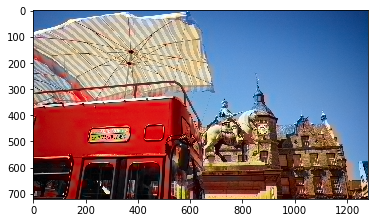

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import os
import skimage.color as color
import scipy.ndimage.interpolation as sni
import caffe
import cv2
import sys

%matplotlib inline

# Select desired model
# .prototxt file contain model architecture
# .caffemodel file contain model weights
net = caffe.Net('./models/colorization_deploy_v2.prototxt', './models/colorization_release_v2.caffemodel', caffe.TEST)

(H_in,W_in) = net.blobs['data_l'].data.shape[2:] # get input shape
(H_out,W_out) = net.blobs['class8_ab'].data.shape[2:] # get output shape

print 'Input dimensions: (%i,%i)'%(H_in,W_in)
print 'Output dimensions: (%i,%i)'%(H_out,W_out)


pts_in_hull = np.load('./resources/pts_in_hull.npy') # load cluster centers
net.params['class8_ab'][0].data[:,:,0,0] = pts_in_hull.transpose((1,0)) # populate cluster centers as 1x1 convolution kernel

my_image = input_path

# load the original image
img_rgb = caffe.io.load_image(my_image)

img_lab = color.rgb2lab(img_rgb) # convert image to lab color space
img_l = img_lab[:,:,0] # pull out L channel
(H_orig,W_orig) = img_rgb.shape[:2] # original image size

# create grayscale version of image (just for displaying)
img_lab_bw = img_lab.copy()
img_lab_bw[:,:,1:] = 0
img_rgb_bw = color.lab2rgb(img_lab_bw)

# resize image to network input size
img_rs = caffe.io.resize_image(img_rgb,(H_in,W_in)) # resize image to network input size
img_lab_rs = color.rgb2lab(img_rs)
img_l_rs = img_lab_rs[:,:,0]

# show original image, along with grayscale input to the network
img_pad = np.ones((H_orig,W_orig/10,3))

net.blobs['data_l'].data[0,0,:,:] = img_l_rs-50 # subtract 50 for mean-centering
net.forward() # run network

ab_dec = net.blobs['class8_ab'].data[0,:,:,:].transpose((1,2,0)) # this is our result
ab_dec_us = sni.zoom(ab_dec,(1.*H_orig/H_out,1.*W_orig/W_out,1)) # upsample to match size of original image L
img_lab_out = np.concatenate((img_l[:,:,np.newaxis],ab_dec_us),axis=2) # concatenate with original image L
img_rgb_out = (255*np.clip(color.lab2rgb(img_lab_out),0,1)).astype('uint8') # convert back to rgb

plt.imsave(output_intermediate, img_rgb_out)
print (output_intermediate)
plt.imshow(img_rgb_out)

# Process output generated by first model

In [42]:
# plots a histogram of the colors given as input
def showColors(colorPalette):
    
    #creating empty chart
    chart = np.zeros((50, 500, 3), np.uint8)

    #creating color rectangles
    start = 0
    for i in range(len(colorPalette)):
        end = start + (500/len(colorPalette))
        
        r = int(colorPalette[i][0])
        g = int(colorPalette[i][1])
        b = int(colorPalette[i][2])

        # using cv2.rectangle to plot colors
        
        cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
        start = end
        
    #display chart
    plt.figure()
    plt.axis("off")
    plt.imshow(chart)
    plt.show()

In [43]:
# calculate Euclidean distance between two points
def euc_dist(point1, point2):
    dist = np.linalg.norm(point1-point2)
    return dist

In [44]:
# function to get image of given dimensions
def getResizedImage(input_path, dim=256):
    img = cv2.imread(input_path)
    img = cv2.resize(img, (dim, dim))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.metrics import davies_bouldin_score, silhouette_score, calinski_harabaz_score
from sklearn.metrics import pairwise_distances_argmin_min
import numpy as np
import sys
from statistics import median

%matplotlib inline

finalizedColors = []

# K-means clustering
class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    ACTUAL_HEIGHT = None
    ACTUAL_WIDTH = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def dominantColors(self, algo="kmeans"):
    
        #read image
        img = getResizedImage(self.IMAGE, 256)
                
        self.ACTUAL_HEIGHT = img.shape[0]
        self.ACTUAL_WIDTH = img.shape[1]
        
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        if(algo=='kmeans'):
            #using k-means to cluster pixels
            model = KMeans(n_clusters = self.CLUSTERS)
        else:
            
            # using mean-shift for clustering pixels
            bandwidth = estimate_bandwidth(img)
            model = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        
        model.fit(img)

        #the cluster centers are our dominant colors.
        self.COLORS = model.cluster_centers_

        #save labels
        self.LABELS = model.labels_
        
        #returning after converting to integer from float
        return self.COLORS.astype(int)
    
    # get the point whose color is most similar to centroid
    def getNearestPointTocentroid(self):
        closest, _ = pairwise_distances_argmin_min(self.COLORS, self.IMAGE)
        return self.IMAGE.take(closest, axis=0)
    
    # get coordinates of point which whose color is most similar to input point
    def getNearestPoint(self, point):
        closestPoints = []
        
        for color in self.IMAGE:
            # all points with a euclidean distance less than 1
            if euc_dist(point,color)<1:
                closestPoints.append(color)
        
        # discard duplicates from closestPoints list
        closestPoints = list(np.unique(closestPoints, axis=0))
        
        coordinateList = []
        
        # get x and y coordinates
        for color in closestPoints:
            coordinateList.append(self.getCoordinates(color))
            
        coordinateList.sort()
        
        coordi = coordinateList[len(coordinateList)/2] 
        
        actualImage = self.IMAGE.reshape(self.ACTUAL_HEIGHT, self.ACTUAL_WIDTH, 3)
        
        finalizedColors.append(actualImage[coordi[0],coordi[1]])
        # return median
        return coordi
            
    # given an RGB value, finds the coordinate of the point with that RGB value
    def getCoordinates(self, point):
        actualImage = self.IMAGE.reshape(self.ACTUAL_HEIGHT, self.ACTUAL_WIDTH, 3)
        templist = []
        for i in range(0,self.ACTUAL_HEIGHT,1):
            for j in range(0,self.ACTUAL_WIDTH,1):
                if euc_dist(actualImage[i,j], point) == 0:
                    templist.append([i,j])
        
        # return median
        return templist[len(templist)/2]
    
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
        
    def calculate_davies_bouldin_score(self):
        return davies_bouldin_score(self.IMAGE, self.LABELS)
    
    def calculate_silhoutte_score(self):
        return silhouette_score(self.IMAGE, self.LABELS)
    
    def calculate_calinski_harabaz_score(self):
        return calinski_harabaz_score(self.IMAGE, self.LABELS)
        
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

Number of clusters: 5
Validation Score: 0.642865384124512

Number of clusters: 6
Validation Score: 0.6260162076167385

Number of clusters: 7
Validation Score: 0.6787785947889902

Number of clusters: 8
Validation Score: 0.7003113045741105

Number of clusters: 9
Validation Score: 0.6946838491184821

Number of clusters: 10
Validation Score: 0.7501488005153354

Number of clusters: 11
Validation Score: 0.8173792458746536

Number of clusters: 12
Validation Score: 0.8173269066865329

Number of clusters: 13
Validation Score: 0.8449247872970729

Number of clusters: 14
Validation Score: 0.8761553155858864

Number of clusters: 15
Validation Score: 0.8867639976941578

Number of clusters: 16
Validation Score: 0.9132110822005934

Number of clusters: 17
Validation Score: 0.9134066061113104

Number of clusters: 18
Validation Score: 0.8767973449821477

Number of clusters: 19
Validation Score: 0.8620292362529397

Number of clusters: 20
Validation Score: 0.8472911862233964



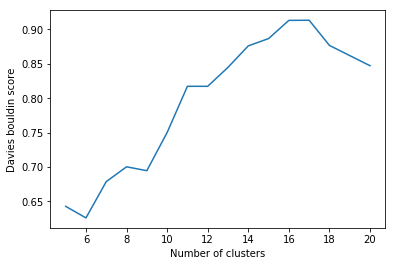

Optimum Clusters: 6


In [46]:
# Analyze k-means for different number of clusters
optimumClusters = 5
validation_scores = []
img = output_intermediate
min_clusters = 5
max_clusters = 21
for i in range(min_clusters, max_clusters, 1):
    clusters = i
    print("Number of clusters: " + str(clusters))
    dc = DominantColors(img, clusters)
    colors = dc.dominantColors()
    db_score = dc.calculate_davies_bouldin_score()
    #db_score = dc.calculate_silhoutte_score()
    #db_score = dc.calculate_calinski_harabaz_score()
    print("Validation Score: " + str(db_score))
    print
    validation_scores.append(db_score)
optimumClusters = np.argmin(validation_scores) + min_clusters

# plot-graph (number of clusters) vs (Davies Bouldin Score)
x = range(min_clusters, max_clusters, 1)
plt.xlabel("Number of clusters")
plt.ylabel("Davies bouldin score")
plt.plot(x,validation_scores)
plt.show()

print("Optimum Clusters: " + str(optimumClusters))

Processing points nearer to: [212 194 169]
Processing points nearer to: [60 25 19]
Processing points nearer to: [145 106  87]
Processing points nearer to: [ 51 104 170]
Processing points nearer to: [193  22  21]
Processing points nearer to: [100 150 206]

Centroid Colors: 


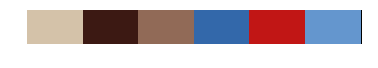

Final Colors: 


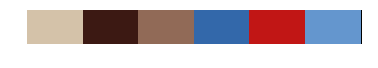

In [58]:
# Perform clustering for optimum number of clusters found in previous step
dc = DominantColors(img, optimumClusters)
colors = dc.dominantColors()

# get the points nearest to the centroids
points = dc.getNearestPointTocentroid()


clusterPoints = []
finalizedColors = []
# get coordinates of point at a distance of [0,1) from the point closest to centroid
for point in points:
    print("Processing points nearer to: " + str(point))
    clusterPoints.append(dc.getNearestPoint(point))
print
print("Centroid Colors: ")    
showColors(points)
print("Final Colors: ")
showColors(finalizedColors)

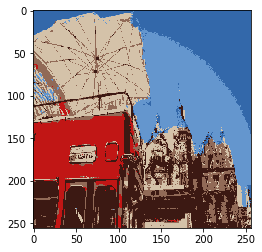

In [59]:
%matplotlib inline
# plot clusters on image using finalized points
i=0
myImage = dc.IMAGE.reshape(dc.ACTUAL_HEIGHT, dc.ACTUAL_WIDTH, 3)
for j in range(256):
    for k in range(256):
        myImage[j,k]=finalizedColors[dc.LABELS[i]]
        i=i+1
plt.imshow(myImage)

In [60]:
print("Final coordinates:")
print(clusterPoints)

Final coordinates:
[[115, 55], [224, 195], [205, 135], [68, 239], [193, 40], [119, 212]]


# Give processed output as input to second model

In [61]:
from data import colorize_image as CI
import matplotlib.pyplot as plt
import numpy as np
import skimage.color as color
import sys
import cv2

# function to put a point on the image
def put_point(input_ab,mask,loc,p,val):
    # input_ab    2x256x256    current user ab input (will be updated)
    # mask        1x256x256    binary mask of current user input (will be updated)
    # loc         2 tuple      (h,w) of where to put the user input
    # p           scalar       half-patch size
    # val         2 tuple      (a,b) value of user input
    input_ab[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = np.array(val)[:,np.newaxis,np.newaxis]
    mask[:,loc[0]-p:loc[0]+p+1,loc[1]-p:loc[1]+p+1] = 1
    return (input_ab,mask)

# Choose gpu to run the model on
gpu_id = -1

# Initialize colorization class
colorModel = CI.ColorizeImageCaffe(Xd=256)

# Load the model
colorModel.prep_net(gpu_id,'./models/reference_model/deploy_nodist.prototxt','./models/reference_model/model.caffemodel')

# Load the black and white image
colorModel.load_image(input_path_bw)

# Load the colored reference image
referenceImage = getResizedImage(output_intermediate)

# extract ab channels of the resized image
referenceImage_lab = color.rgb2lab(referenceImage)

# initialize with no user inputs
input_ab = np.zeros((2,256,256))
mask = np.zeros((1,256,256))

# add points in the image
numberOfPoints = len(clusterPoints)
    
for i in range(numberOfPoints):
    coordinate = clusterPoints[i]
    xx = coordinate[0]
    yy = coordinate[1]
    color_to_put = referenceImage_lab[xx,yy]
    (input_ab, mask) = put_point(input_ab,mask,[xx,yy],3,[color_to_put[1], color_to_put[2]])

# call forward
img_out = colorModel.net_forward(input_ab,mask)

# get mask, input image, and result in full resolution
mask_fullres = colorModel.get_img_mask_fullres() # get input mask in full res
img_in_fullres = colorModel.get_input_img_fullres() # get input image in full res
img_out_fullres = colorModel.get_img_fullres() # get image at full resolution

plt.imsave(output_path,img_out_fullres)

ColorizeImageCaffe instantiated
gpu_id = -1, net_path = ./models/reference_model/deploy_nodist.prototxt, model_path = ./models/reference_model/model.caffemodel


# Show final results

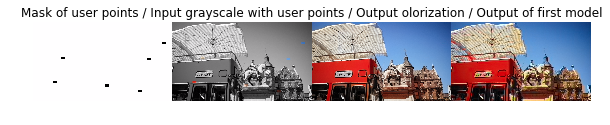

In [62]:
# show user input, along with output
%matplotlib inline
intermediate_image = cv2.imread(output_intermediate)
intermediate_image = cv2.cvtColor(intermediate_image, cv2.COLOR_BGR2RGB)
intermediate_image = cv2.resize(intermediate_image, (mask_fullres.shape[1], mask_fullres.shape[0]))

plt.figure(figsize=(10,6))
plt.imshow(np.concatenate((mask_fullres,img_in_fullres,img_out_fullres, intermediate_image),axis=1));
plt.title('Mask of user points / Input grayscale with user points / Output olorization / Output of first model')
plt.axis('off');

# Calculate Error

In [47]:
# function to calculate MSE in two images
def calculateMse(img1, img2):
    l = img1.shape[0]
    b = img1.shape[1]
    SSE = 0
    for i in range(l):
        for j in range(b):
            SSE = SSE + (euc_dist(img1[i][j], img2[i][j])**2)
    
    MSE = SSE/(256*256)
    return MSE
            

In [29]:
imgs_folder = './Output/Batch/original/'
output_intermediate_folder = './Quantitative/first_model/'
output_final_folder = './Quantitative/our/'
image_name = '43051.jpg'
img1 = getResizedImage('./Quantitative/original/' + image_name)
img2 = getResizedImage('./Quantitative/first_model/' + image_name)
# img2 = getResizedImage('./Quantitative/our/' + image_name)
calculateMse(img1, img2)

78850.4782409668

In [48]:
def readImages(folder, images):
    for filename in os.listdir(folder):
        images.append(filename)
    print(images)

In [51]:
imgs_folder = './Outputs/Batch/imgs/'
output_intermediate_folder = './Outputs/Batch/output_intermediate/'
output_final_folder = './Outputs/Batch/output_final/'

lst_imgs = []
lst_output_intermediate = []
lst_output_final = []

readImages(imgs_folder, lst_imgs)
readImages(output_intermediate_folder, lst_output_intermediate)
readImages(output_final_folder, lst_output_final)

['100007.jpg', '100039.jpg', '100099.jpg', '10081.jpg', '101027.jpg', '101084.jpg', '102062.jpg', '103006.jpg', '103029.jpg', '103078.jpg', '104010.jpg', '104055.jpg', '105027.jpg', '106005.jpg', '106047.jpg', '107014.jpg', '107045.jpg', '107072.jpg', '108004.jpg', '268048.jpg', '268074.jpg', '277053.jpg', '279005.jpg', '28083.jpg', '281017.jpg', '285022.jpg', '288024.jpg', '289011.jpg', '290035.jpg', '29030.jpg', '296028.jpg', '296058.jpg', '302022.jpg', '306051.jpg', '306052.jpg', '3063.jpg', '309040.jpg', '317043.jpg', '326025.jpg', '326085.jpg', '33044.jpg', '335088.jpg', '335094.jpg', '344010.jpg', '346016.jpg', '347031.jpg', '35028.jpg', '35049.jpg', '36046.jpg', '365072.jpg', '368037.jpg', '372019.jpg', '376086.jpg', '384022.jpg', '384089.jpg', '385022.jpg', '388006.jpg', '388018.jpg', '388067.jpg', '393035.jpg', '41029.jpg', '41085.jpg', '41096.jpg', '43033.jpg', '43051.jpg', '45000.jpg', '48017.jpg', '48025.jpg', '49024.jpg', '5096.jpg', '51084.jpg', '6046.jpg', '61034.jpg', '

In [53]:
cnt = 0
overall_SSE = 0
for i,j in zip(lst_imgs, lst_output_intermediate):
    cnt = cnt + 1
    print(cnt)
    img1 = getResizedImage(imgs_folder + i)
#     img2 = getResizedImage(output_intermediate_folder + j)
    img2 = getResizedImage(output_final_folder + j)
    overall_SSE = overall_SSE + calculateMse(img1, img2)
overall_RMSE=(overall_SSE/200)**(0.5);
print(overall_RMSE)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
261.0935190653667


In [54]:
output_intermediate = 263.2388212289924
output_final = 261.0935190653667
print(output_intermediate)
print(output_final)

263.238821229
261.093519065
